In [30]:
%matplotlib inline

import os
import re


In [31]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [32]:
# !pipenv install transformers sentencepiece

In [33]:
import Bio

In [34]:
def read_fasta(file_path, columns):
    from Bio.SeqIO.FastaIO import SimpleFastaParser
    with open(file_path) as fasta_file:
        records = []
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits = title.split(None)
            record.append(title[0])
            sequence = "".join(sequence)
            record.append(sequence)
            record.append(len(sequence))
            location_splits = title_splits[1].split("-")
            record.append(location_splits[0])
            record.append(location_splits[1])
            
            if (len(title_splits)) > 2:
                record.append(0)
            else:
                record.append(1)
            
            records.append(record)
            
        return pd.DataFrame(records, columns=columns)

In [35]:
data = read_fasta('deeploc_data.fasta.txt', columns=["id", "sequence", "sequence_length", "location", "membrane", "is_train"])

data.head()

,id,sequence,sequence_length,location,membrane,is_train
0,Q,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...,295,Cell.membrane,M,0
1,Q,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,566,Cell.membrane,M,1
2,P,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,266,Cell.membrane,M,1
3,Q,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,780,Cell.membrane,M,1
4,Q,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,240,Cell.membrane,M,1


In [36]:
len(data)

14004

In [37]:
data['sequence_length'].describe()

count    14004.00000
mean       522.44166
std        448.06671
min         40.00000
25%        249.00000
50%        421.00000
75%        649.00000
max      13100.00000
Name: sequence_length, dtype: float64

In [38]:
data = data[data['sequence_length'] < 1000] # 今回は低計算量にしたいのでマシンのスペック的に、アミノ酸の長さを1000未満に絞る
len(data)

12614

(0.0, 1000.0)

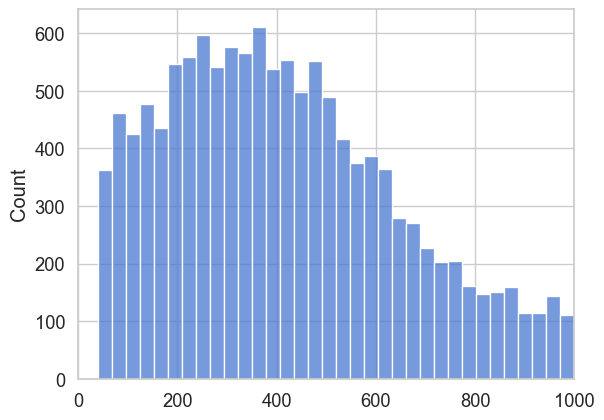

In [39]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
ax = sns.histplot(data['sequence_length'].values)
ax.set_xlim(0, 1000) # x軸の表示範囲の設定

In [40]:
data.isnull().values.any() # 欠損値の確認

False

In [41]:
unique_classes = data.location.unique()
print('Number of classes: ', len(unique_classes))
print(unique_classes)

Number of classes:  10
['Cell.membrane' 'Cytoplasm' 'Endoplasmic.reticulum' 'Golgi.apparatus'
 'Lysosome/Vacuole' 'Mitochondrion' 'Nucleus' 'Peroxisome' 'Plastid'
 'Extracellular']


In [42]:
# カテゴリ変数の変換
catagories = data.location.astype('category').cat # pandasではcategory型が存在する。
data['location'] = catagories.codes
class_names = catagories.categories

num_classes = len(class_names)
print(class_names)


Index(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum', 'Extracellular',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid'],
      dtype='object')


In [43]:
data['location'] #符号化できていることを確認する。

0        0
1        0
2        0
3        0
4        0
        ..
13999    3
14000    3
14001    3
14002    3
14003    3
Name: location, Length: 12614, dtype: int8

In [44]:
df_train = data[data.is_train == 1]
df_train = df_train.drop(['is_train'], axis=1) # is_train列を削除した。
print(df_train.shape[0])
df_train.head()

10169


,id,sequence,sequence_length,location,membrane
1,Q,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,566,0,M
2,P,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,266,0,M
3,Q,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,780,0,M
4,Q,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,240,0,M
5,A,MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWR...,653,0,M


In [45]:
df_test = data[data.is_train == 0]
df_test = df_test.drop(['is_train'], axis=1)
print(df_test.shape[0])
df_test.head()

2445


,id,sequence,sequence_length,location,membrane
0,Q,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...,295,0,M
9,P,AGFPEQEPEPKFWNDWAQKTLDKALSLQTLNKNKAQNLILFLGDGM...,477,0,M
20,Q,MHSRLKFLAYLHFICASSIFWPEFSSAQQQQQTVSLTEKIPLGAIF...,991,0,M
23,P,MAAATAAAATVAGEGMEPRALQYEQTLMYGRYTQELGAFAKEEAAR...,907,0,M
29,P,MEQSRSQQRGGEQSWWGSDPQYQYMPFEHCTSYGLPSENGGLQHRL...,988,0,M


## 事前学習済みタンパク質言語モデルのダウンロード

In [ ]:
from transformers import T5EncoderModel, T5Tokenizer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

In [47]:
def get_T5_model():
    model = T5EncoderModel.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc')
    model = model.to(device)
    model = model.eval()
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
    
    return model, tokenizer
    

In [48]:
model, tokenizer = get_T5_model()

c:\Users\owner\.virtualenvs\bioinformatics-abR04bHa\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\owner\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [49]:
train_sequences = { i: seq for i, seq in enumerate(df_train['sequence']) }
train_sequences

{0: 'MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFLAQLMMFLISFISSVFCGHLGKLELDAVTLAIAVINVTGISVGHGLSSACDTLISQTYGSQNLKHVGVILQRGTLILLLCCFPCWALFINTEQILLLFRQDPDVSRLTQTYVMVFIPALPAAFLYTLQVKYLLNQGIVLPQVITGIAANLVNALANYLFLHQLHLGVMGSALANTISQFALAIFLFLYILWRKLHHATWGGWSWECLQDWASFLQLAIPSMLMLCIEWWAYEVGSFLSGILGMVELGAQSITYELAIIVYMIPAGFSVAANVRVGNALGAGNIDQAKKSSAISLIVTELFAVTFCVLLLGCKDLVGYIFTTDWDIVALVAQVVPIYAVSHLFEALACTCGGVLRGTGNQKVGAIVNAIGYYVIGLPIGISLMFVAKLGVIGLWSGIIICSVCQTSCFLVFIARLNWKLACQQAQVHANLKVNVALNSAVSQEPAHPVGPESHGEIMMTDLEKKDEIQLDQQMNQQQALPVHPKDSNKLSGKQLALRRGLLFLGVVLVLVGGILVRVYIRTE',
 1: 'MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIEDFHRKVYNIHGDMYQLDILDTSGNHPFPAMRRLSILTGDVFILVFSLDSRESFDEVKRLQKQILEVKSCLKNKTKEAAELPMVICGNKNDHSELCRQVPAMEAELLVSGDENCAYFEVSAKKNTNVNEMFYVLFSMAKLPHEMSPALHHKISVQYGDAFHPRPFCMRRTKVAGAYGMVSPFARRPSVNSDLKYIKAKVLREGQARERDKCSIQ',
 2: 'MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGGHFFSTTQSPPATQGSTAAQRSTATQHSTATQSSTATQTSPVPLTPESPLFQNFSGYHIGVGRADCTGQVADINLMGYGKSGQNAQGILTRLYSRAFIMAEP

In [50]:
len(train_sequences)

10169

In [51]:
test_sequences = { i: seq.replace(' ', '') for i , seq in enumerate(df_test['sequence'])}


In [52]:
len(test_sequences)

2445

In [ ]:
def get_embeddings(model, tokenizer, seqs, max_residues=4000, max_seq_len=1000, max_batch=100):
    results = {'protein_embs': dict()}
    seq_dict = sorted(seqs.items(), key=lambda kv: len( seqs[kv[0]]), reverse=True)
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict, 1):
        seq = seq
        seq_len = len(seq)
        seq = ' '.join(list(seq))
        batch.append((pdb_id, seq, seq_len))
        
        n_res_batch = sum([ s_len for _, _, s_len in batch]) + seq_len
        if len(batch) >= max_batch or n_res_batch >=  max_residues or seq_idx==len(seq_dict) or seq_len>max_residues:
            pdb_id, seqs, seq_len = zip(*batch)
            batch = list()
            
            token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding='longest')
            input_ids = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
            